In [1]:
import os
import sys
from tqdm import trange
from tqdm import tqdm
from skimage.util import montage
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

# 导入上一个文件目录input下的文件
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../input/medmnist-integration/")))

# 导入 medmnist 包
import medmnist
from medmnist.models import ResNet18, ResNet50
from medmnist.dataset import PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST, OrganMNISTAxial, OrganMNISTCoronal, OrganMNISTSagittal, MedMNIST
from medmnist.evaluator import getAUC, getACC, save_results
from medmnist.info import INFO


In [2]:
print("Version:", medmnist.__version__)

Version: 0.2.2


## Common Functions

In [3]:
# peak at the data
def peak_dataset(dataset:MedMNIST, random:bool=False, size:tuple=(1,1), figsize:tuple=(4, 4)):
    y, x = size
    fig, ax = plt.subplots(x, y, figsize=figsize)

    if x == 1:
        ax = [ax]
    if y == 1:
        ax = [[i] for i in ax]

    for i in range(x):
        for j in range(y):
            # randomize the index
            if random:
                index = np.random.randint(len(dataset))
            else:
                index = i * y + j
            img, target = dataset[index]
            if int(dataset.info['n_channels']) == 3:
                img = img.permute(1, 2, 0)
            else:
                img = img.reshape(img.shape[1:])
            ax[i][j].imshow(img, cmap='gray')
            ax[i][j].set_title(target)
            ax[i][j].axis('off')
    plt.show()

In [4]:
# montage
def montage_dataset(dataset, n_channels, length=20):
    scale = length * length

    # 首先根据指定的通道数和边长创建一个空的图像数组
    image = np.zeros((scale, 28, 28, 3)) if n_channels == 3 else np.zeros((scale, 28, 28))

    # 然后随机选取scale个样本，将其填充到图像数组中
    index = [i for i in range(scale)]
    np.random.shuffle(index)
    
    for idx in range(scale):
        img, _ = dataset[idx]
        if n_channels == 3:
            img = img.permute(1, 2, 0).numpy() # permute：重新排列维度
        else:
            img = img.reshape(28, 28).numpy()
        image[index[idx]] = img
    
    print(image.shape)
    # plt.figure()

    if n_channels == 1:
        image = image.reshape(scale, 28, 28)
        arr_out = montage(image)
        plt.imshow(arr_out, cmap='gray')
    else:
        image = image.reshape(scale, 28, 28, 3)
        arr_out = montage(image, multichannel=3)
        plt.imshow(arr_out)
    

In [5]:
def set_end_epoch(EPOCHS:int=100):
    DEVMODE = os.getenv("KAGGLE_MODE") == "DEV"
    # print(f"DEV MODE: {DEVMODE}")
    EPOCHS = 2 if DEVMODE else EPOCHS
    print(f"EPOCHS: {EPOCHS}")
    return EPOCHS

In [6]:
def set_output_dir(output_dir:str="./", foldname:str="unspecified"):
    DEVMODE = os.getenv("KAGGLE_MODE") == "DEV"
    # print(f"DEV MODE: {DEVMODE}")
    OUTPUT_DIR = "./local_output/" + foldname if DEVMODE else output_dir + foldname
    print(f"OUTPUT_DIR: {OUTPUT_DIR}")
    return OUTPUT_DIR

# set_output_dir(output_dir="output", foldname="resnet18")

In [7]:
def train(model, optimizer, criterion, train_loader, device, train_loss_list, task):
    ''' training function
    :param model: the model to train
    :param optimizer: optimizer used in training
    :param criterion: loss function
    :param train_loader: DataLoader of training set
    :param device: cpu or cuda
    :param task: task of current dataset, binary-class/multi-class/multi-label, binary-class

    '''
    loss_list = []

    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))

        loss_list = []

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            loss_list.append(loss.item())
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            loss_list.append(loss.item())
            # print("train outputs:", outputs.shape, outputs)
            # print("train targets:", targets.shape, targets)

        loss.backward()
        optimizer.step()
    train_loss_list.append(np.mean(loss_list))

In [8]:
max_auc = 1
def val(model, val_loader, device, val_auc_list, task, dir_path, epoch):
    ''' validation function
    :param model: the model to validate
    :param val_loader: DataLoader of validation set
    :param device: cpu or cuda
    :param val_auc_list: the list to save AUC score of each epoch
    :param task: task of current dataset, binary-class/multi-class/multi-label, binary-class
    :param dir_path: where to save model
    :param epoch: current epoch

    '''

    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            outputs = model(inputs.to(device))

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                m = nn.Sigmoid()
                outputs = m(outputs).to(device)
            else:
                targets = targets.squeeze().long().to(device)
                m = nn.Softmax(dim=1)
                outputs = m(outputs).to(device)
                targets = targets.float().resize_(len(targets), 1)
                # print("val outputs:", outputs.shape, outputs)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()
        auc = getAUC(y_true, y_score, task)
        val_auc_list.append(auc)

    state = {
        'net': model.state_dict(),
        'auc': auc,
        'epoch': epoch,
    }

    # 只保留auc最大的模型
    if epoch == 0:
        global max_auc
        max_auc = auc
        path = os.path.join(dir_path, 'ckpt_%d_auc_%.5f.pth' % (epoch, auc))
        torch.save(state, path)
    else:
        if auc > max_auc:
            max_auc = auc
            path = os.path.join(dir_path, 'ckpt_%d_auc_%.5f.pth' % (epoch, auc))
            torch.save(state, path)
            # 删除auc小的模型文件
            for file in os.listdir(dir_path):
                if file.endswith(".pth") and file != 'ckpt_%d_auc_%.5f.pth' % (epoch, auc):
                    os.remove(os.path.join(dir_path, file))
        else:
            pass
    # path = os.path.join(dir_path, 'ckpt_%d_auc_%.5f.pth' % (epoch, auc))
    # torch.save(state, path)

In [9]:
def test(model, split, data_loader, device, flag, task, output_root=None):
    ''' testing function
    :param model: the model to test
    :param split: the data to test, 'train/val/test'
    :param data_loader: DataLoader of data
    :param device: cpu or cuda
    :param flag: subset name
    :param task: task of current dataset, binary-class/multi-class/multi-label, binary-class

    '''

    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            outputs = model(inputs.to(device))

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                m = nn.Sigmoid()
                outputs = m(outputs).to(device)
            else:
                targets = targets.squeeze().long().to(device)
                m = nn.Softmax(dim=1)
                outputs = m(outputs).to(device)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()
        auc = getAUC(y_true, y_score, task)
        acc = getACC(y_true, y_score, task)
        print('%s AUC: %.5f ACC: %.5f' % (split, auc, acc))

        if output_root is not None:
            output_dir = os.path.join(output_root, flag)
            if not os.path.exists(output_dir):
                os.mkdir(output_dir)
            output_path = os.path.join(output_dir, '%s.csv' % (split))
            save_results(y_true, y_score, output_path)

In [10]:

# 所有的数据集
flag_to_class = {
    "pathmnist": PathMNIST,
    "chestmnist": ChestMNIST,
    "dermamnist": DermaMNIST,
    "octmnist": OCTMNIST,
    "pneumoniamnist": PneumoniaMNIST,
    "retinamnist": RetinaMNIST,
    "breastmnist": BreastMNIST,
    "organmnist_axial": OrganMNISTAxial,
    "organmnist_coronal": OrganMNISTCoronal,
    "organmnist_sagittal": OrganMNISTSagittal,
}

In [11]:
import pandas as pd

columns = ["Model", "Dataset", "AUC", "ACC"]
overall_table = pd.DataFrame(columns=columns)

def append2table(model:str, dataset:str, auc:float, acc:float):
    global overall_table
    ex_pd = pd.DataFrame([[model, dataset, auc, acc]], columns=columns)
    overall_table = pd.concat([overall_table, ex_pd], axis=0)

# ex_pd = pd.DataFrame([["ResNet18", "PathMNIST", 0.5, 0.5]], columns=["model", "Dataset", "AUC", "ACC"])

In [12]:
def create_dataset_info(model:str, flag:str, lr:float, batch_size:int, end_epoch:int):
    return {
        'input_root': '../input/medmnist-integration',
        'output_root': './output/',
        'download': False,
        'model': model,
        'flag': flag,
        'lr': lr,
        'batch_size': batch_size,
        'end_epoch': set_end_epoch(end_epoch)
    }

In [13]:
# peak at the data

def loss_visualization(p, loss:list, title:str, xlabal:str, ylabel:str):
    p.plot(loss)
    p.set_title(title)
    p.set_xlabel(xlabal)
    p.set_ylabel(ylabel)
    p.legend(['train'], loc='upper right')

def heat_visualization(infos:dict, p,y_true:list, y_score:list, title:str):
    from sklearn.metrics import accuracy_score, confusion_matrix

    auc = getAUC(y_true, y_score, infos['task'])
    acc = getACC(y_true, y_score, infos['task'])

    cm = confusion_matrix(y_true, np.round(y_score[:, -1]))

    # tn, fp, fn, tp = cm.ravel()

    # print(f'\n============{title} METRICS=============')
    # precision = tp/(tp+fp)
    # recall = tp/(tp+fn)

    if 'test' == title:
        append2table(infos['model'], infos['flag'], auc, acc)

    # 绘制混淆矩阵
    p.imshow(cm, cmap='coolwarm', interpolation='nearest')
    p.set_title(f'{title} Heatmap')
    p.axis('off')

    rows, cols = cm.shape
    for i in range(rows):
        for j in range(cols):
            p.text(j, i, f'{cm[i][j]:.2f}', ha='center', va='center', color='white')


def auc_visualization(p,y_true:list, y_score:list, title:str):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc

    fpr , tpr , thresholds = roc_curve ( y_true=y_true, y_score=y_score[:, -1])
    auc_keras = auc(fpr, tpr)
    lw = 2
    p.plot(fpr, tpr, color='darkorange',
            lw=lw, label=title + ' AUC (area = %0.2f)' % auc_keras)
    p.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    p.set_xlim([0.0, 1.0])
    p.set_ylim([0.0, 1.05])
    p.set_xlabel('False Positive Rate')
    p.set_ylabel('True Positive Rate')
    p.set_title(title + ' AUC')
    p.legend(loc="lower right")

    

def visulazation(infos:dict, loss:list, typelist:list):
    import pandas as pd
    fig_size = 5
    fig_num = len(typelist)

    # loss 曲线
    fig_loss, ax_loss = plt.subplots(1, 1, figsize=(fig_size, fig_size))
    loss_visualization(ax_loss, loss, 'train_loss', 'epoch', 'loss')

    fig, ax = plt.subplots(1, fig_num, figsize=(fig_size * fig_num, fig_size))

    output_root = set_output_dir(infos['output_root'], infos['model'])

    pd_list = [pd.read_csv(output_root + '/' + infos['flag'] + '/' + csvType + '.csv') for csvType in typelist]
    pd_list = [p.set_index('id') for p in pd_list]


    y_true_list = [p['true_0'].values for p in pd_list]
    y_score_list = [p[['score_0', 'score_1']].values for p in pd_list]

    # auc 曲线
    for i in range(len(typelist)):
        auc_visualization(ax[i], y_true_list[i], y_score_list[i], typelist[i])

    # heat 曲线
    fig_heat, ax_heat = plt.subplots(1, fig_num, figsize=(fig_size * fig_num, fig_size))
    
    for i in range(len(typelist)):
        heat_visualization(infos, ax_heat[i], y_true_list[i], y_score_list[i], typelist[i])

    # ax[i].axis('off')
    plt.show()

In [14]:
def reproduction(infos:dict):
    flag = infos["flag"]
    DataClass = flag_to_class[flag]

    download = infos["download"]
    input_root = infos["input_root"]
    output_root = set_output_dir(output_dir=infos['output_root'], foldname=infos['model'])

    info = INFO[flag]
    task = info['task']
    infos['task'] = task
    n_channels = info['n_channels'] # 图片数据的通道
    n_classes = len(info['label']) # 类别个数


    start_epoch = 0
    end_epoch = infos["end_epoch"]
    lr = infos["lr"]
    batch_size = infos["batch_size"]
    val_auc_list = []
    train_loss_list = []

    dir_path = os.path.join(output_root, '%s_checkpoints' % (flag))
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        
    print('==> Preparing data...')
    # 数据预处理transform准备：转换成tensor，并normalize到0-1
    train_transform = transforms.Compose(
        [transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5])])

    val_transform = transforms.Compose(
        [transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5])])

    test_transform = transforms.Compose(
        [transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5])])

    # 载入数据
    train_dataset = DataClass(root=input_root,
                                    split='train',
                                    transform=train_transform,
                                    download=download)
    train_loader = data.DataLoader(dataset=train_dataset,
                                    batch_size=batch_size,
                                    shuffle=True)
    val_dataset = DataClass(root=input_root,
                                    split='val',
                                    transform=val_transform,
                                    download=download)
    val_loader = data.DataLoader(dataset=val_dataset,
                                    batch_size=batch_size,
                                    shuffle=True)
    test_dataset = DataClass(root=input_root,
                                    split='test',
                                    transform=test_transform,
                                    download=download)
    test_loader = data.DataLoader(dataset=test_dataset,
                                    batch_size=batch_size,
                                    shuffle=True)
    peak_dataset(train_dataset, random=True, size=(4, 1), figsize=(4, 4))
    montage_dataset(train_dataset, n_channels, length=20)

    print('==> Building and training model...')

    network = ResNet18 if infos['model'] == 'ResNet18' else ResNet50

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = network(in_channels=n_channels, num_classes=n_classes).to(device)

    if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss() # TODO: 研究一下这个分类器
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) # 优化器使用的是随机梯度下降

    for epoch in trange(start_epoch, end_epoch):
        train(model, optimizer, criterion, train_loader, device, train_loss_list, task)
        val(model, val_loader, device, val_auc_list, task, dir_path, epoch)

    auc_list = np.array(val_auc_list)
    index = auc_list.argmax()
    print('epoch %s is the best model' % (index))

    print('==> Testing model...')
    restore_model_path = os.path.join(
        dir_path, 'ckpt_%d_auc_%.5f.pth' % (index, auc_list[index]))
    model.load_state_dict(torch.load(restore_model_path)['net'])
    test(model,
         'train',
         train_loader,
         device,
         flag,
         task,
         output_root=output_root)
    test(model,
         'val', 
         val_loader, 
         device, 
         flag, 
         task, 
         output_root=output_root)
    test(model,
         'test',
         test_loader,
         device,
         flag,
         task,
         output_root=output_root)
    visulazation(infos, train_loss_list, typelist=['train', 'val', 'test'])

## ResNet18


In [15]:
MODEL = "ResNet18"

### 肺炎数据集

EPOCHS: 2
OUTPUT_DIR: ./local_output/ResNet18
==> Preparing data...


/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


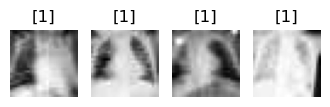

(400, 28, 28)
==> Building and training model...


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [02:25<00:00, 72.59s/it]


epoch 1 is the best model
==> Testing model...
train AUC: 0.99626 ACC: 0.97324
val AUC: 0.99035 ACC: 0.94847
test AUC: 0.95438 ACC: 0.84455
OUTPUT_DIR: ./local_output/ResNet18


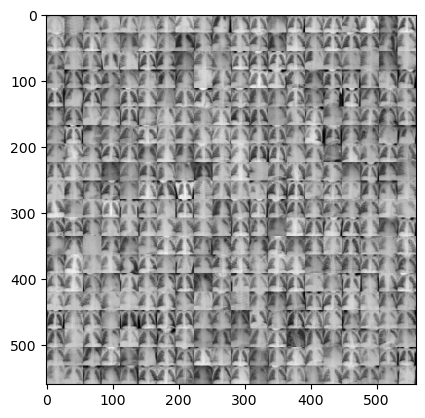

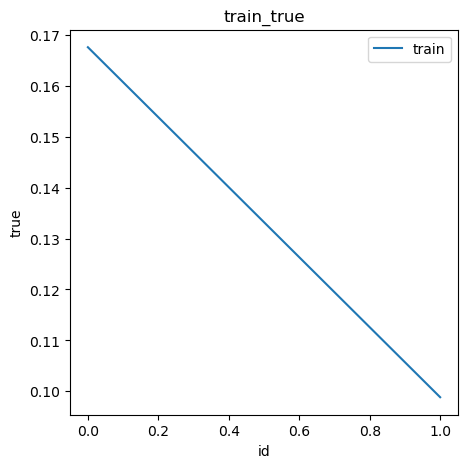

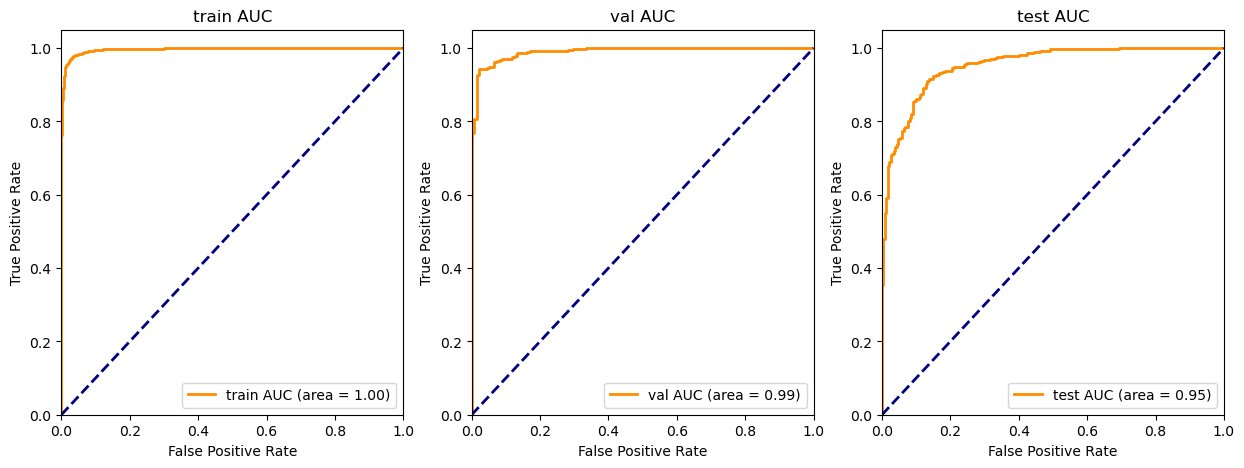

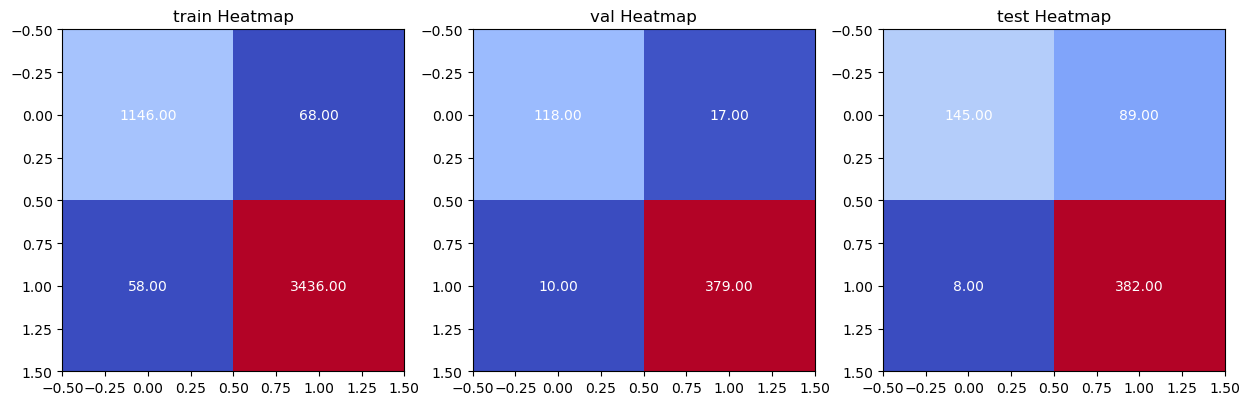

In [16]:
infos = create_dataset_info(MODEL, "pneumoniamnist", 0.001, 128, 100)

reproduction(infos)

### 乳房超声据集

EPOCHS: 2
OUTPUT_DIR: ./local_output/ResNet18
==> Preparing data...


/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


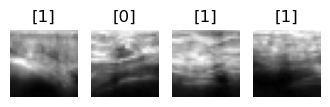

(400, 28, 28)
==> Building and training model...


100%|██████████| 2/2 [00:23<00:00, 11.65s/it]


epoch 0 is the best model
==> Testing model...
train AUC: 0.70391 ACC: 0.50366
val AUC: 0.79282 ACC: 0.53846
test AUC: 0.67836 ACC: 0.56410
OUTPUT_DIR: ./local_output/ResNet18


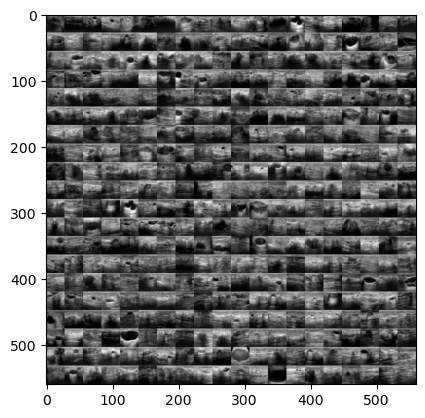

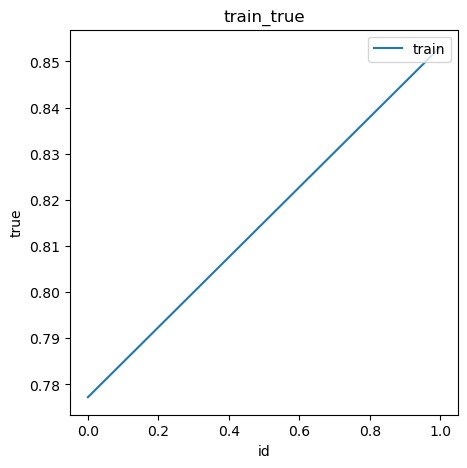

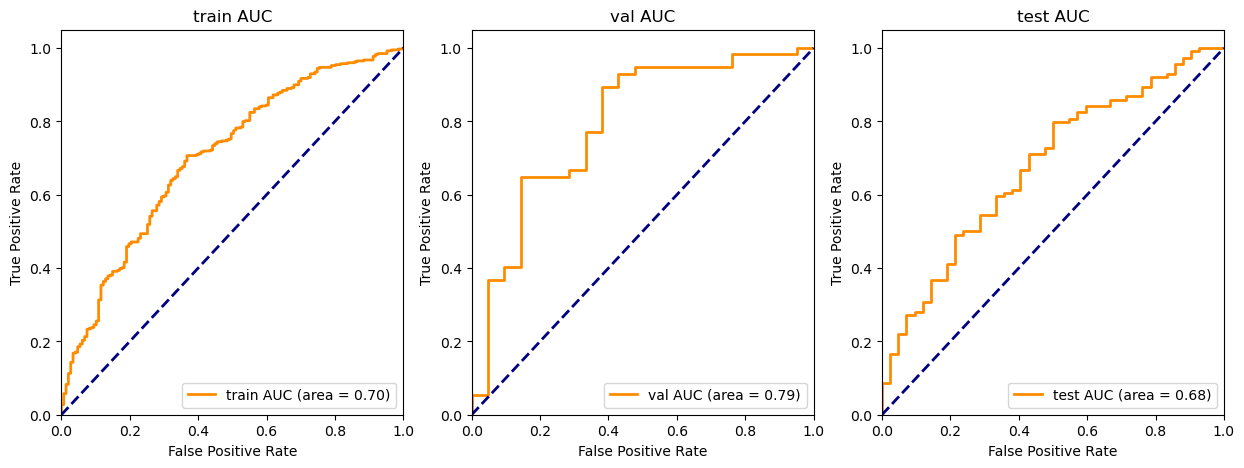

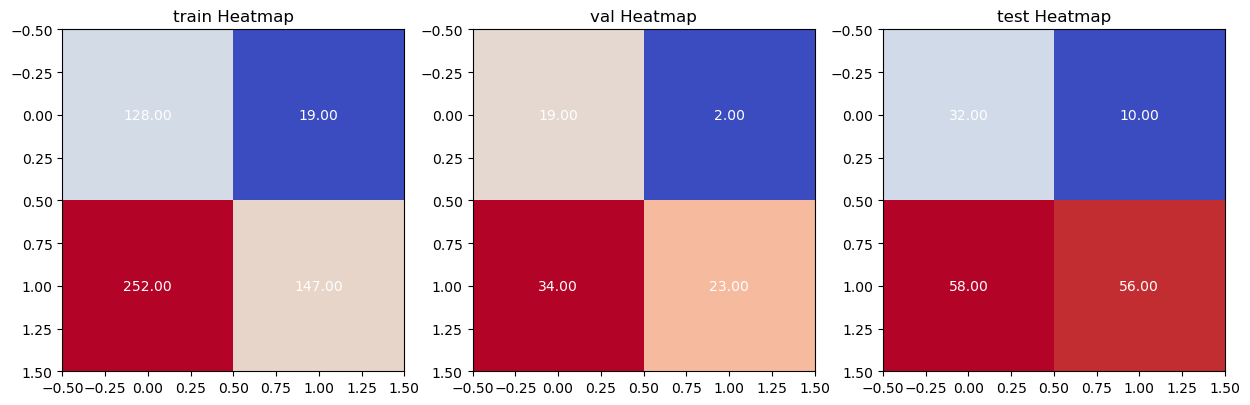

In [17]:
infos = create_dataset_info(MODEL, "breastmnist", 0.001, 24, 100)

reproduction(infos)

## ResNet50

In [18]:
MODEL = "ResNet50"

### 肺炎数据集

EPOCHS: 2
OUTPUT_DIR: ./local_output/ResNet50
==> Preparing data...


/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


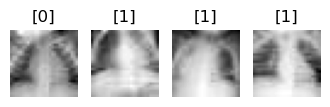

(400, 28, 28)
==> Building and training model...


100%|██████████| 2/2 [08:42<00:00, 261.03s/it]


epoch 1 is the best model
==> Testing model...
train AUC: 0.98255 ACC: 0.93415
val AUC: 0.97985 ACC: 0.93702
test AUC: 0.92642 ACC: 0.83654
OUTPUT_DIR: ./local_output/ResNet50


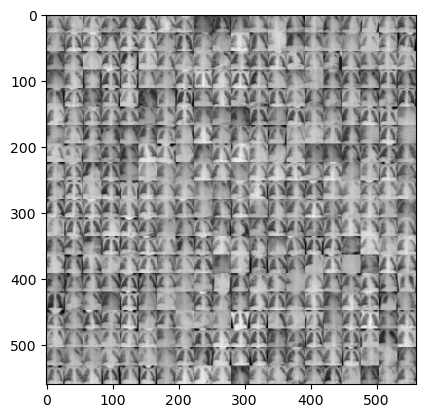

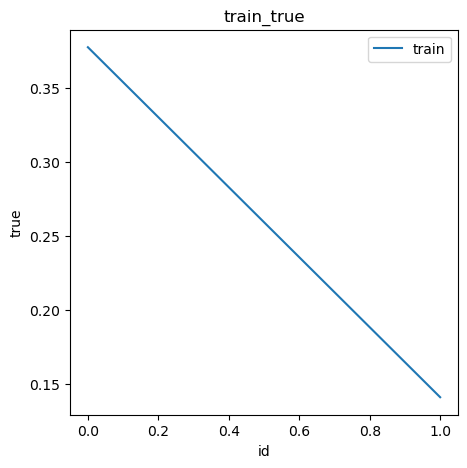

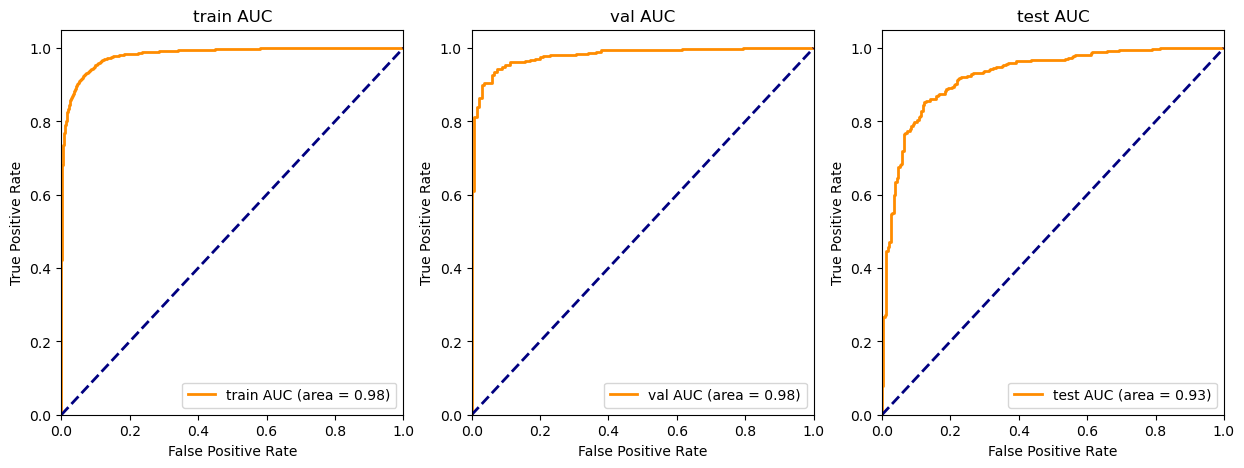

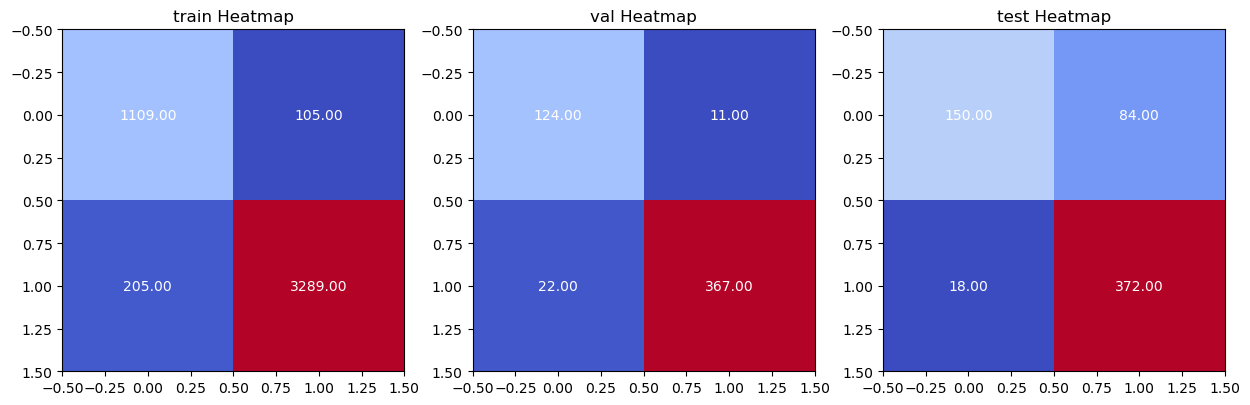

In [19]:
infos = create_dataset_info(MODEL, "pneumoniamnist", 0.001, 128, 100)

reproduction(infos)

### 乳房超声据集

EPOCHS: 2
OUTPUT_DIR: ./local_output/ResNet50
==> Preparing data...


/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


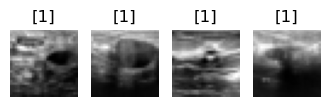

(400, 28, 28)
==> Building and training model...


100%|██████████| 2/2 [01:15<00:00, 37.77s/it]


epoch 1 is the best model
==> Testing model...
train AUC: 0.69478 ACC: 0.72894
val AUC: 0.69256 ACC: 0.73077
test AUC: 0.65769 ACC: 0.73077
OUTPUT_DIR: ./local_output/ResNet50


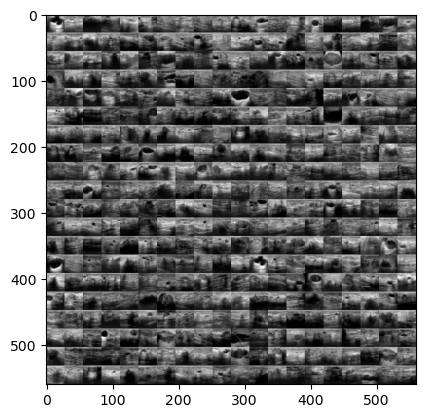

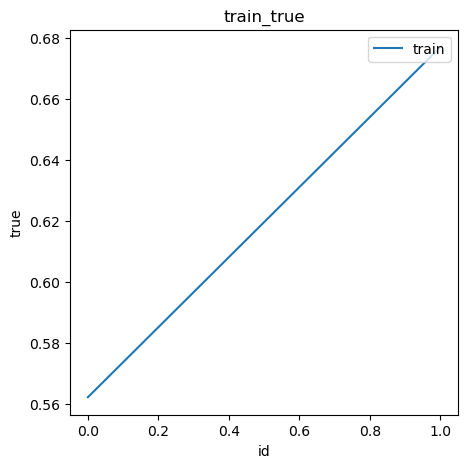

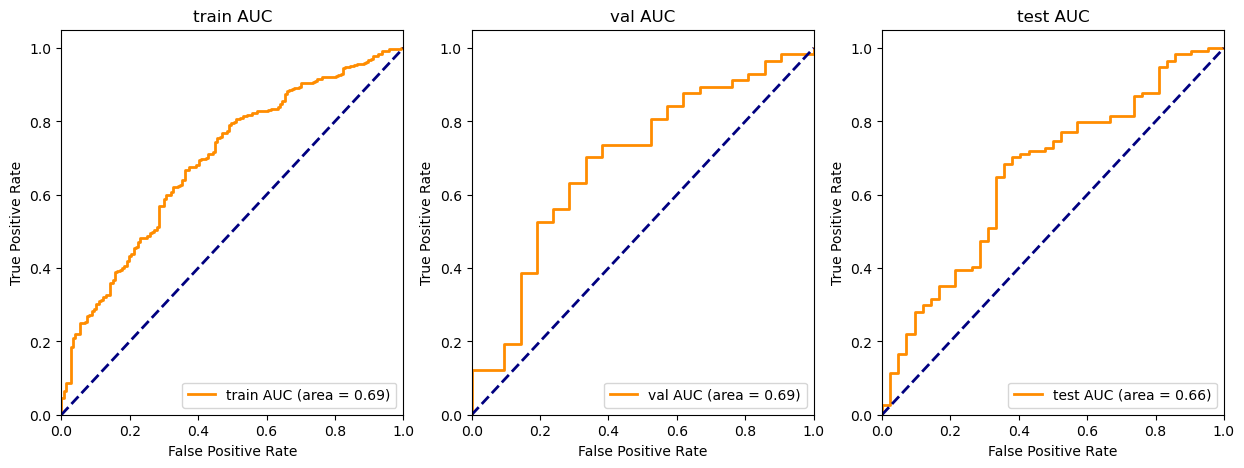

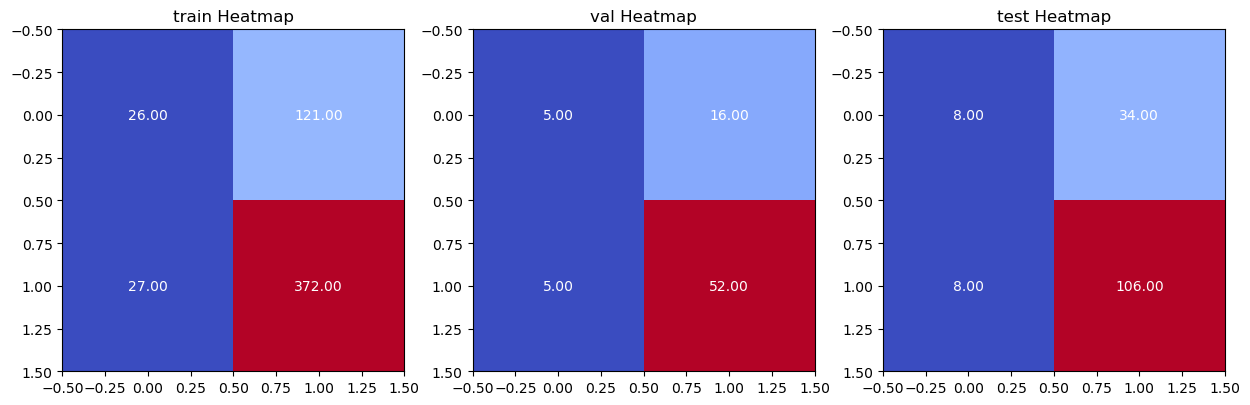

In [20]:
infos = create_dataset_info(MODEL, "breastmnist", 0.001, 24, 100)

reproduction(infos)

### 汇总图

In [21]:
overall_table.set_index(['Dataset', 'Model'], inplace=False)

ACC       AUC
Dataset        Model                       
pneumoniamnist ResNet18  0.973237  0.996265
               ResNet18  0.948473  0.990346
               ResNet18  0.844551  0.954383
breastmnist    ResNet18  0.503663  0.703911
               ResNet18  0.538462  0.792815
               ResNet18  0.564103  0.678363
pneumoniamnist ResNet50  0.934155  0.982552
               ResNet50  0.937023  0.979853
               ResNet50  0.836538  0.926419
breastmnist    ResNet50  0.728938  0.694781
               ResNet50  0.730769  0.692565
               ResNet50  0.730769  0.657686